In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image

**Note**: Since the original path points to a local directory on your machine, I'll assume the dataset is publicly available and add code to download it. **You'll need to replace the placeholder URL with the actual URL of your dataset.**

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# Example: https://www.kaggle.com/datasets/akshat108/e-waste-image-dataset
!kaggle datasets download -d akshat103/e-waste-image-dataset

Dataset URL: https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset
License(s): apache-2.0
  0% 0.00/11.8M [00:00<?, ?B/s]
100% 11.8M/11.8M [00:00<00:00, 949MB/s]


In [6]:
!unzip e-waste-image-dataset.zip

Archive:  e-waste-image-dataset.zip
  inflating: modified-dataset/test/Battery/battery_106.jpg  
  inflating: modified-dataset/test/Battery/battery_128.jpg  
  inflating: modified-dataset/test/Battery/battery_148.jpg  
  inflating: modified-dataset/test/Battery/battery_152.jpg  
  inflating: modified-dataset/test/Battery/battery_174.jpg  
  inflating: modified-dataset/test/Battery/battery_177.jpg  
  inflating: modified-dataset/test/Battery/battery_190.jpg  
  inflating: modified-dataset/test/Battery/battery_192.jpg  
  inflating: modified-dataset/test/Battery/battery_211.jpg  
  inflating: modified-dataset/test/Battery/battery_22.jpg  
  inflating: modified-dataset/test/Battery/battery_24.jpg  
  inflating: modified-dataset/test/Battery/battery_241.jpg  
  inflating: modified-dataset/test/Battery/battery_242.jpg  
  inflating: modified-dataset/test/Battery/battery_251.jpg  
  inflating: modified-dataset/test/Battery/battery_259.jpg  
  inflating: modified-dataset/test/Battery/battery_

In [7]:
testpath="/content/modified-dataset/test"
trainpath="/content/modified-dataset/train"
validpath="/content/modified-dataset/val"

In [8]:
datatrain=tf.keras.preprocessing.image_dataset_from_directory(trainpath,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              image_size=(128,128))

Found 2400 files belonging to 10 classes.


In [9]:
datatest=tf.keras.preprocessing.image_dataset_from_directory(testpath,
                                                              batch_size=32,
                                                             shuffle=True,
                                                              image_size=(128,128))

Found 300 files belonging to 10 classes.


In [10]:
datavalid=tf.keras.preprocessing.image_dataset_from_directory(validpath,
                                                              batch_size=32,
                                                              shuffle=True,
                                                              image_size=(128,128))

Found 300 files belonging to 10 classes.


In [11]:
class_names = datatrain.class_names
print(class_names)
print(len(class_names))

['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
10


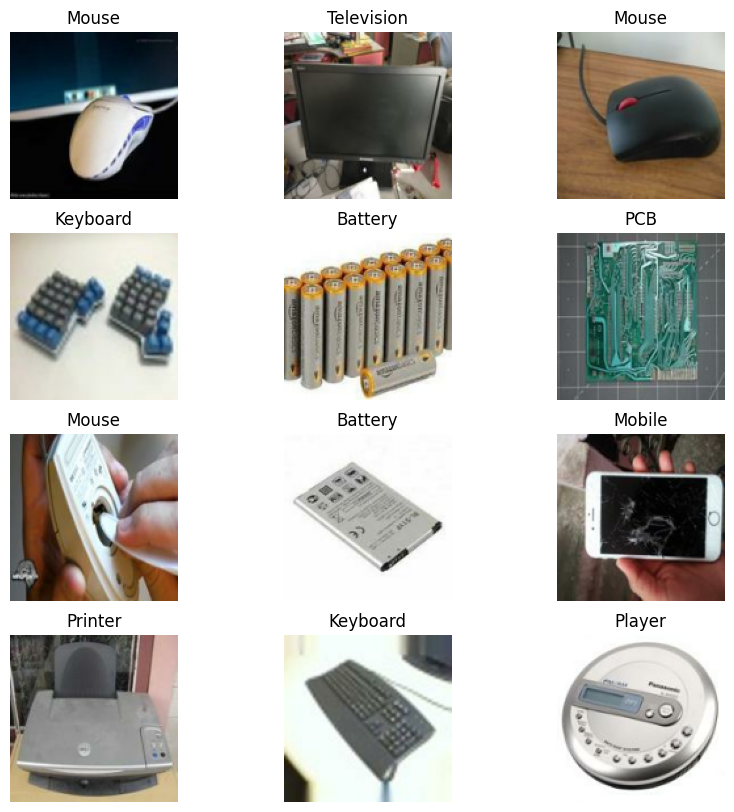

In [12]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [13]:
def plot_class_distribution(dataset, title="Class Distribution"):

    class_counts={}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


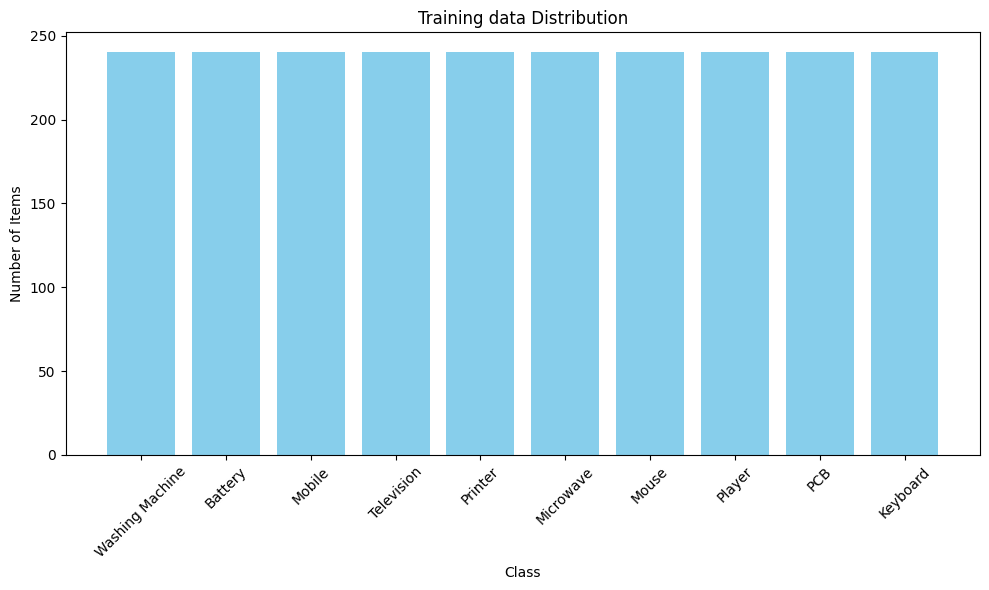

In [14]:
plot_class_distribution(datatrain, title="Training data Distribution")

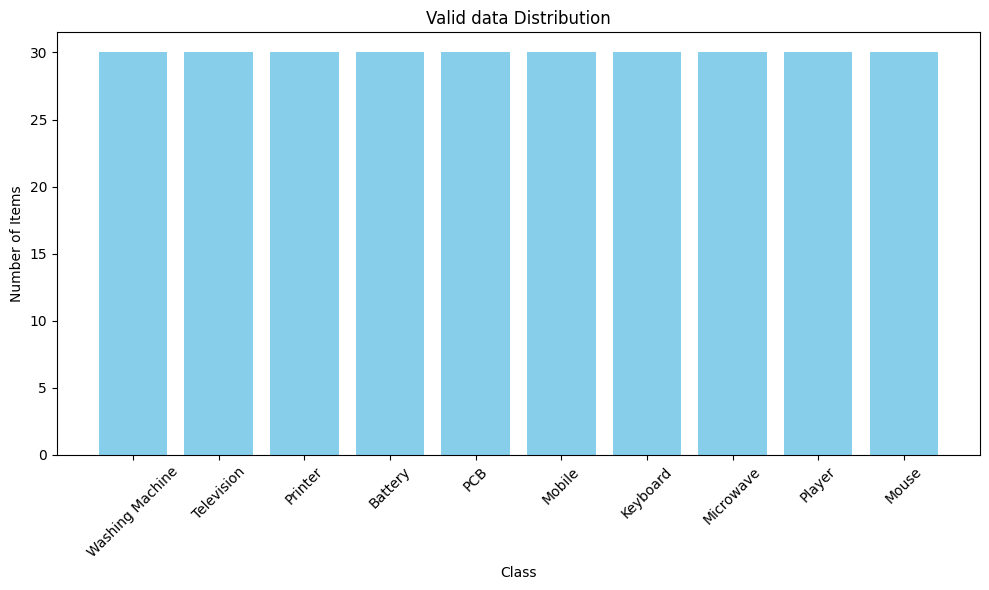

In [15]:
plot_class_distribution(datavalid, title="Valid data Distribution")


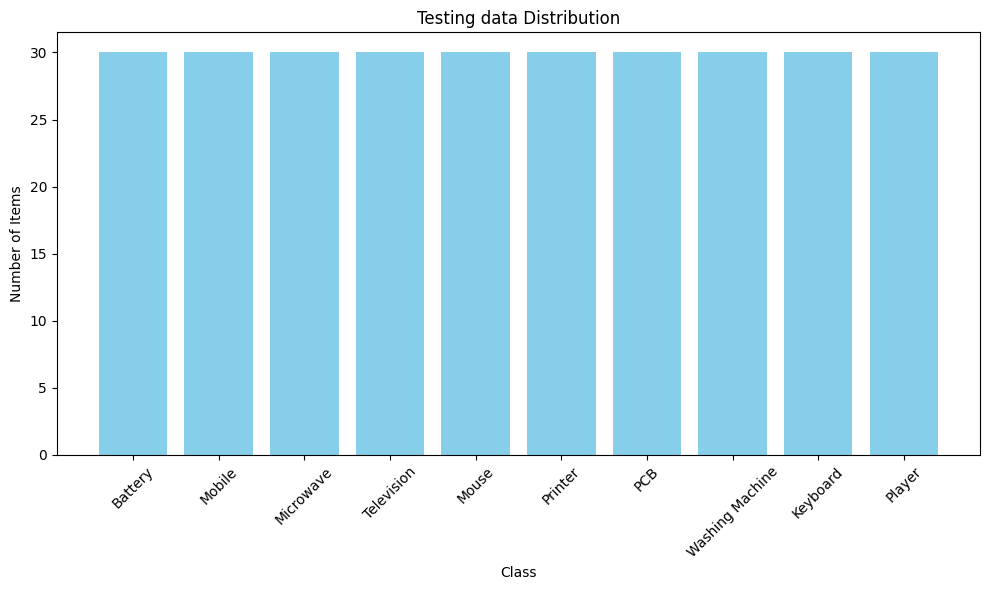

In [16]:
plot_class_distribution(datatest, title="Testing data Distribution")


In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [18]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [20]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [21]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - Accuracy: 0.2319 - loss: 2.1509 - val_Accuracy: 0.7600 - val_loss: 1.1775
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - Accuracy: 0.7656 - loss: 0.9903 - val_Accuracy: 0.8933 - val_loss: 0.5251
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - Accuracy: 0.8673 - loss: 0.5238 - val_Accuracy: 0.9167 - val_loss: 0.3189
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - Accuracy: 0.9012 - loss: 0.3373 - val_Accuracy: 0.9333 - val_loss: 0.2451
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - Accuracy: 0.9336 - loss: 0.2451 - val_Accuracy: 0.9367 - val_loss: 0.2063
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - Accuracy: 0.9510 - loss: 0.1922 - val_Accuracy: 0.9467 - val_loss: 0.1869
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - Accuracy: 0.9540 - loss: 0.1612 - val_Accuracy: 0.9467 - val_loss: 0.1798
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - Accuracy: 0.9695 - loss: 0.1227 - val_Accuracy: 0.946

In [22]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [23]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [24]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

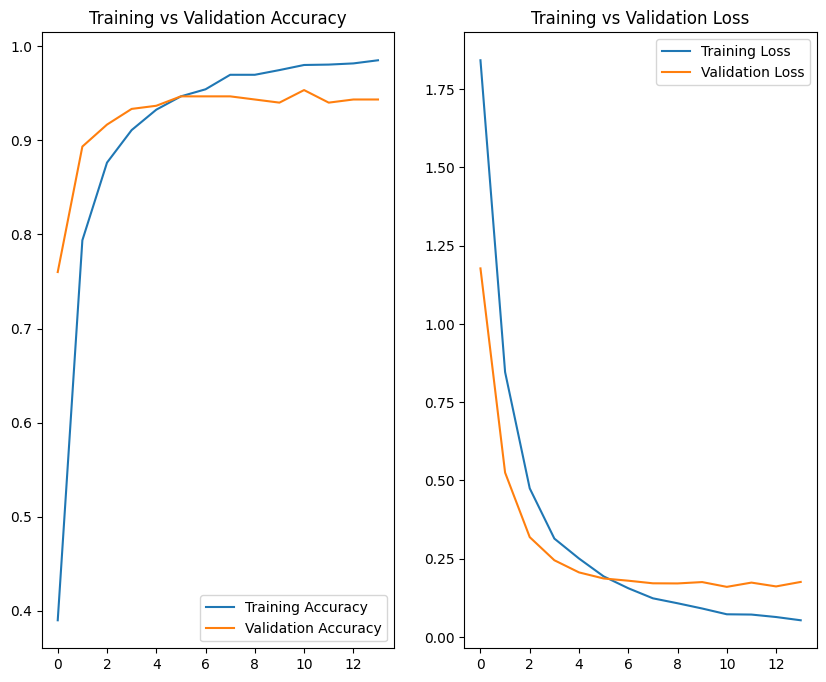

In [25]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [26]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - Accuracy: 0.9358 - loss: 0.1515
Test accuracy is0.9333, Test loss is 0.1553


In [27]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step
[[4 3 2 1 1 3 4 4 5 3]
 [2 2 5 3 3 5 1 4 3 2]
 [5 1 5 3 4 2 2 5 2 1]
 [3 2 3 2 2 5 3 2 3 5]
 [4 4 3 2 3 3 3 3 0 5]
 [2 3 3 5 4 3 3 4 1 2]
 [3 3 4 1 2 5 2 2 5 3]
 [2 3 2 4 2 4 4 5 2 2]
 [1 4 3 3 7 1 5 1 2 3]
 [1 5 2 6 3 2 3 1 2 5]]
              precision    recall  f1-score   support

           0       0.15      0.13      0.14        30
           1       0.07      0.07      0.07        30
           2       0.16      0.17      0.16        30
           3       0.07      0.07      0.07        30
           4       0.10      0.10      0.10        30
           5       0.09      0.10      0.10        30
           6       0.07      0.07      0.07        30
           7       0.16      0.17      0.16        30
           8       0.08      0.07      0.07        30
           9       0.16      0.17      0.16        30

    accuracy                           0.11       300
   macro avg       0.11      0.11      0.11       300
weighted avg       0.11 

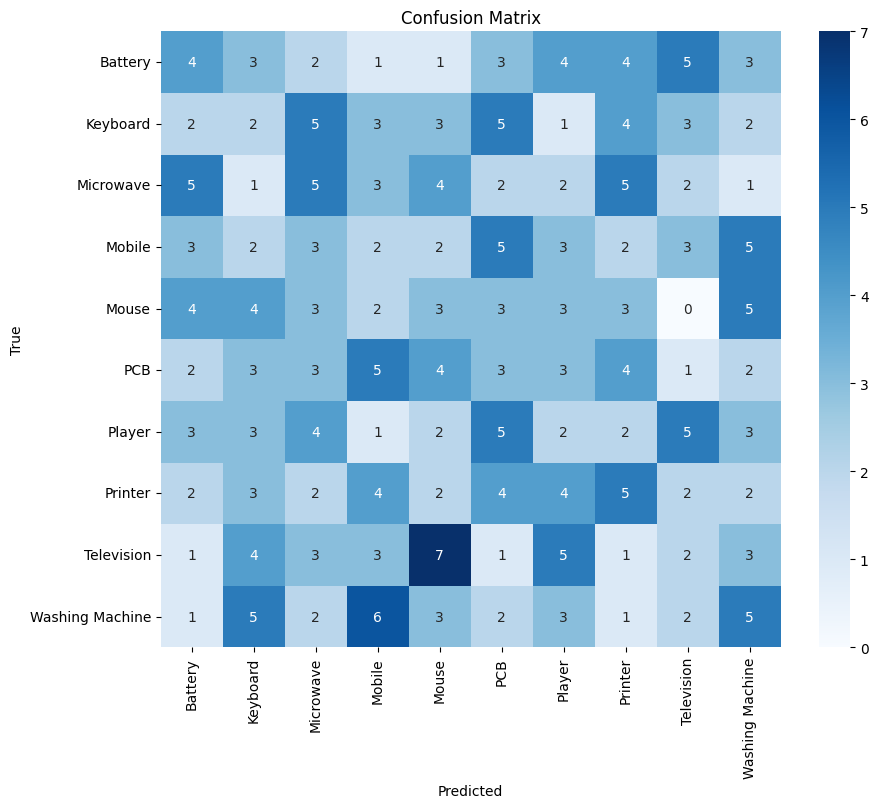

In [28]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


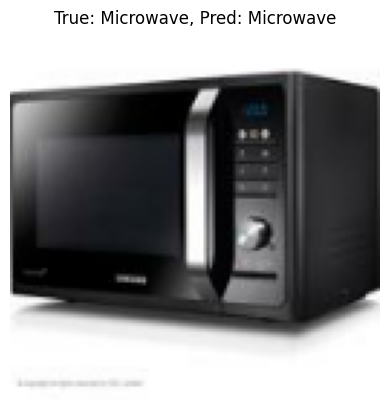

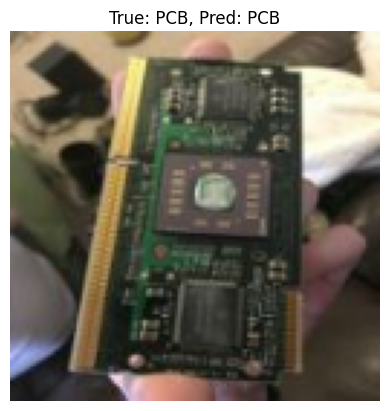

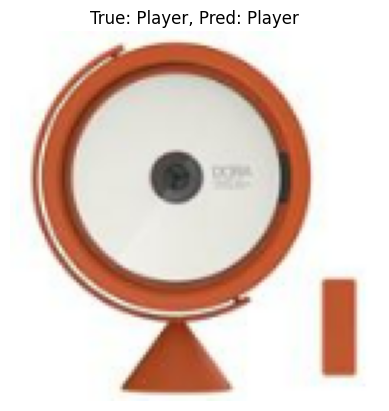

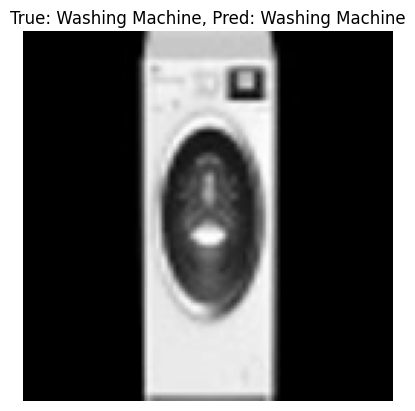

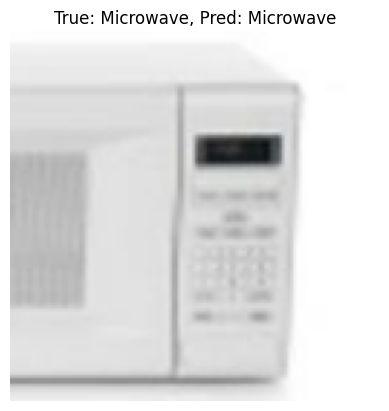

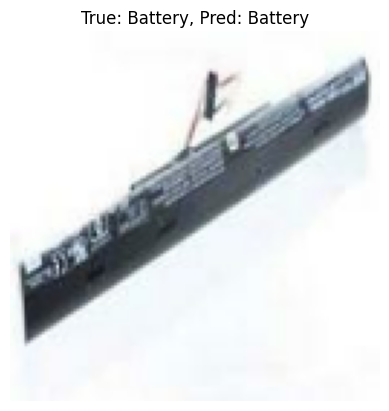

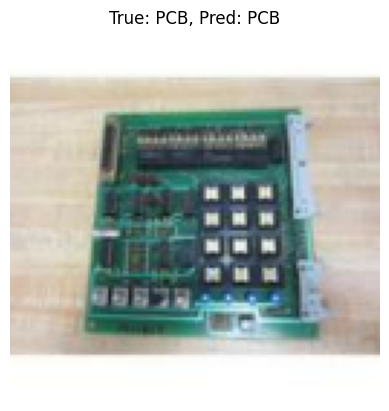

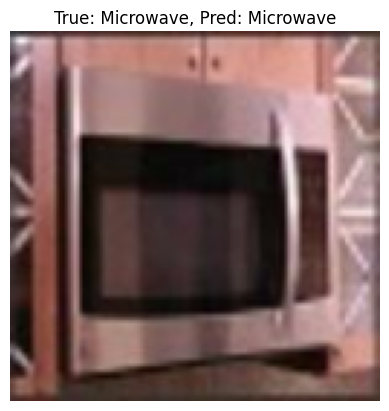

In [29]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image

In [30]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [31]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')